# Capstone Project: Shopping Coupon Recommendation

**Business Objective**: In this captsone project, a customer ecommerce shooping transaction data from Kaggle is used to evaluate data and compare the performance of recommendation models using Surprise library. The business objective of this project is to recommend coupons for the brand where a user have most event_type - viewed, in-cart or purchased.

This notebook contains the Exploratory Data Analysis (EDA) and plots of the selected dataset.

#### Libraries used in this application

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import squarify
import os

from matplotlib import rcParams
from scipy.linalg import svd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
from surprise import Dataset, Reader, SVD, NMF, KNNBasic, SlopeOne, CoClustering, accuracy, BaselineOnly
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from collections import defaultdict
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import process

import warnings
warnings.filterwarnings('ignore')

#### Data Understanding

In [8]:
shopping = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/shopping.csv')

The data for this project can be downloaded for this [kaggle](https://www.kaggle.com/code/danofer/ecommerce-store-predict-purchases-data-prep/data?select=2019-Nov.csv). This file contains behavior data for a one month (November 2019) from a large multi-category online store. 

Each row in the file represents an user event. All events are related to products and users. There are different types of events.

- event_time: Time when event happened at (in UTC).

- event_type : can be:
view - a user viewed a product
cart - a user added a product to shopping cart
purchase - a user purchased a product
Typical funnel: view => cart => purchase

- product_id: ID of a product

- category_id: Product's category ID

- category_code: multi-hierarchical name of Product's category

- brand: Downcased string of brand name

- price: Float price of a product. Present

- user_id: Permanent user ID

- user_session: Temporary user's session ID. Same for each user's session. Is changed every time user come back to online store from a long pause.

In [9]:
shopping.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


In [10]:
shopping.isnull().sum()

event_time              0
event_type              0
product_id              0
category_id             0
category_code    13515609
brand             6117080
price                   0
user_id                 0
user_session            2
dtype: int64

#### Data Preparation

In [11]:
# Since the dataset is too large for analysis, I am dropping all the NaN values in the dataframe
shopping = shopping.dropna()

In [12]:
# Checking for null values
shopping.isnull().sum()

event_time       0
event_type       0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
user_session     0
dtype: int64

In [13]:
shopping.shape

(26560620, 9)

In [14]:
# Data Sampling - Since the dataset is still very large for the analysis, taking only a sample of the data for this application
shopping_sample = shopping.sample(frac=0.002, random_state=42)

In [15]:
shopping_sample.shape

(53121, 9)

In [16]:
# Since 'category_code' has multiple levels, breaking the levels to hierarchical codes. Level 0 - Category Code and Level 1 & 2 - Product Code
shopping_sample['category_code_new'] = shopping_sample['category_code'].str.split('.', expand=True)[0]

In [17]:
# Creating 'product_code' from level-1 and level-2 from 'category_code'
shopping_sample.loc[shopping_sample['category_code'].str.split('.', expand=True)[2] != ' ', 'product_code'] = shopping_sample['category_code'].str.split('.', expand=True)[2]
shopping_sample.loc[shopping_sample['category_code'].str.split('.', expand=True)[2].isnull(), 'product_code'] = shopping_sample['category_code'].str.split('.', expand=True)[1]

In [18]:
# Dropping the 'category_code' from the dataset
shopping_sample = shopping_sample.drop('category_code', axis=1)

In [19]:
# Renaming the new category_code column
shopping_sample = shopping_sample.rename(columns={'category_code_new': 'category_code'})

In [20]:
# Leveraging 'event_time' to calculate the shopping trip time
yr=  shopping_sample.event_time.str.slice(0,4)
mo = shopping_sample.event_time.str.slice(5,7)
da = shopping_sample.event_time.str.slice(8,10)
time = shopping_sample.event_time.str.slice(10,-3).str.strip()
time_zone = shopping_sample.event_time.str.slice(-3).str.strip()

In [21]:
hr = time.str.slice(0,2).str.strip()
min = time.str.slice(3,5).str.strip()
sec= time.str.slice(6).str.strip()
hr = hr.str.zfill(2)
min=min.str.zfill(2)
sec= sec.str.zfill(2)

In [22]:
mo = mo.str.zfill(2)
da =da.str.zfill(2)

In [23]:
time_df = pd.DataFrame({'hr':hr,'min':min,'sec':sec})
time = time_df.astype(str).apply(":".join,axis=1)

In [24]:
shopping_sample['shopping_time'] = time

In [25]:
shopping_sample['shopping_time'] = pd.to_datetime(shopping_sample['shopping_time'], format="%H:%M:%S").dt.hour

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa1b2df4250>,
      dtype=object)

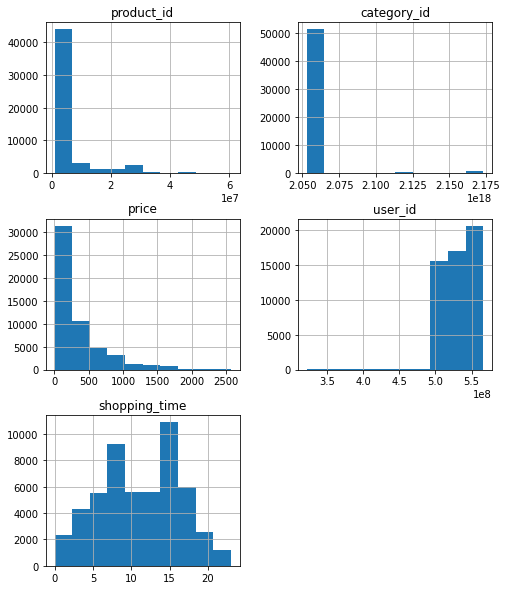

In [26]:
rcParams['figure.figsize'] = 8,10
shopping_sample.hist()

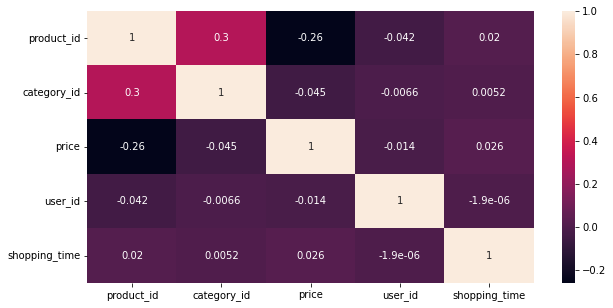

In [27]:
# Creating a Correlation Matrix to understand the correlation between numeric columns
rcParams['figure.figsize'] = 10,5
sns.heatmap(shopping_sample.corr(), annot=True)
# There is some correlation between price and shopping_time

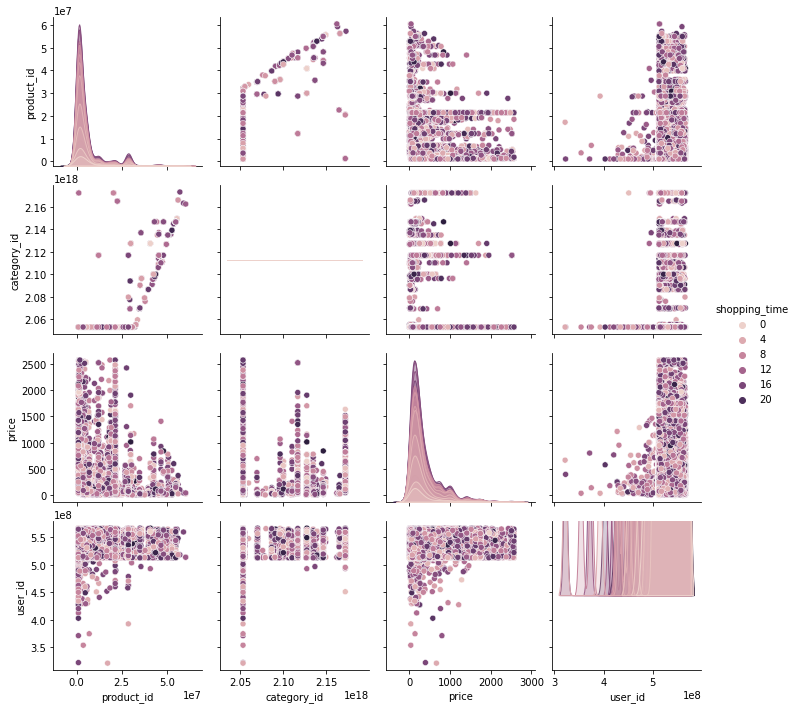

In [28]:
sns.pairplot(data=shopping_sample, hue='shopping_time')

In [29]:
# Dropping columns that are not needed for this analysis
shopping_sample.drop(['event_time', 'product_id', 'category_id', 'user_session'], axis=1, inplace=True)

In [30]:
# Creating a target column that combines the user and brand feature
#shopping_sample["user_brand"] = (shopping_sample['user_id'].astype(str)+shopping_sample['brand'].astype(str)).astype('category').cat.codes.astype('object')

In [31]:
# Rearraging the columns for better readability
column_order = ['user_id', 'brand', 'category_code', 'product_code', 'price', 'event_type', 'shopping_time']
shopping_sample = shopping_sample.reindex(columns=column_order)

In [32]:
shopping_sample.head()

,user_id,brand,category_code,product_code,price,event_type,shopping_time
32953609,513706639,starline,auto,alarm,420.09,view,15
42403729,518135646,apple,electronics,smartphone,949.47,view,20
22060003,513692818,apple,electronics,smartphone,1088.70,view,3
11351928,514596160,artel,electronics,tv,239.59,view,17
9961705,558153369,acer,computers,notebook,643.49,view,17


In [33]:
# Saving the cleaned up sample dataframe as a .csv file
shopping_sample.to_csv('/content/drive/MyDrive/Colab Notebooks/data/shopping_sample.csv')

#### Data Visualization

Text(0.5, 1.0, 'Shopping Category')

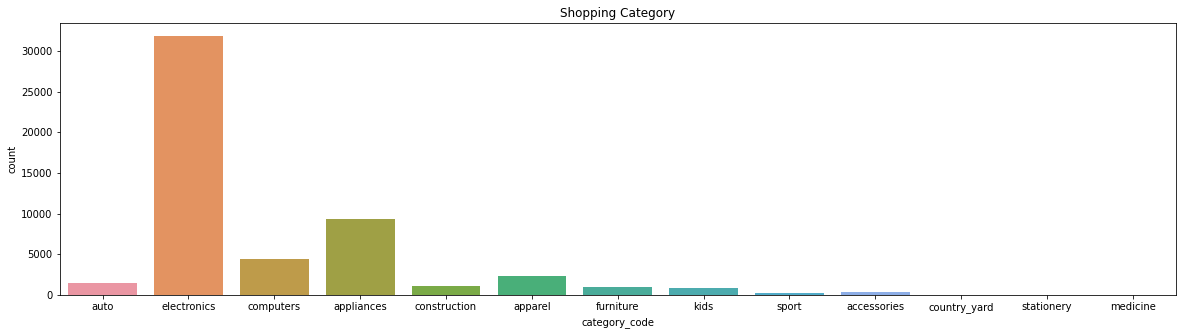

In [34]:
# Shopping Category
rcParams['figure.figsize'] = 20,5
sns.countplot(data=shopping_sample, x='category_code')
plt.title('Shopping Category')
# For the selected sample, 'electronics' is the most common shopping category viewed, in cart or purchased

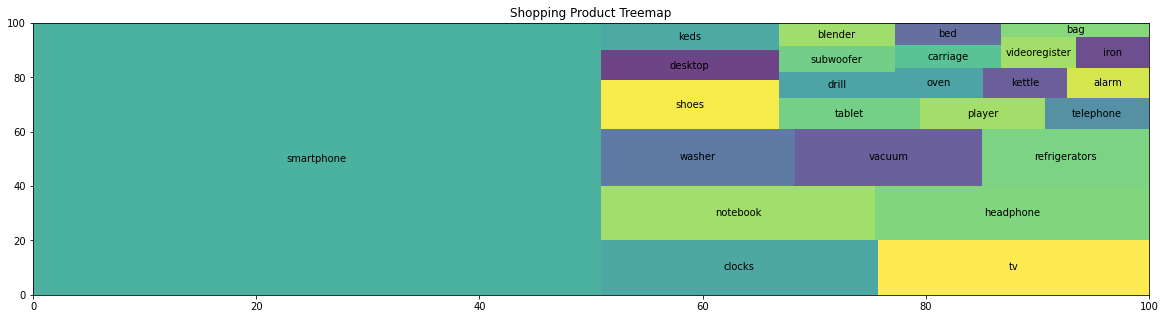

In [35]:
# Shopping Product - Top 25
rcParams['figure.figsize'] = 20, 5
squarify.plot(sizes=shopping_sample['product_code'].value_counts().iloc[:25].tolist(), label=shopping_sample['product_code'].value_counts().iloc[:25].keys().tolist(), alpha=0.8)
plt.title('Shopping Product Treemap')
#plt.axis('off')
plt.show()
# For the selected sample, 'smartphone' is the most common shopping product viewed, in cart or purchased

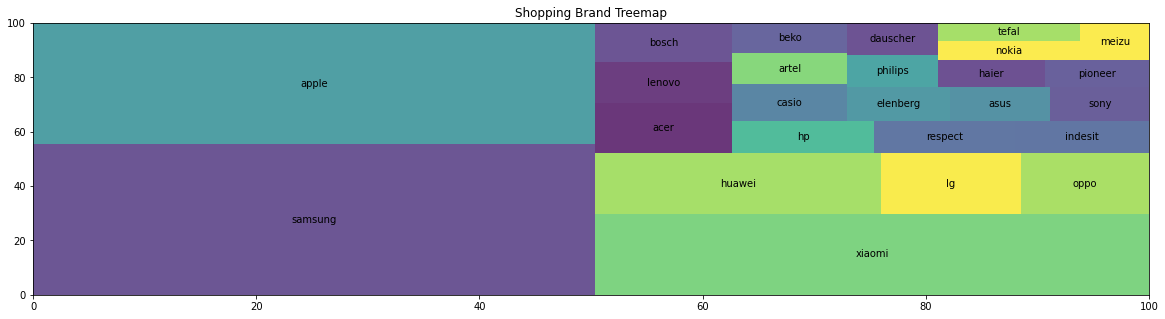

In [36]:
# Shopping Brand - Top 25
rcParams['figure.figsize'] = 20, 5
squarify.plot(sizes=shopping_sample['brand'].value_counts().iloc[:25].tolist(), label=shopping_sample['brand'].value_counts().iloc[:25].keys().tolist(), alpha=0.8)
plt.title('Shopping Brand Treemap')
#plt.axis('off')
plt.show()
# For the selected sample, 'samsung' and 'apple' are the most common shopping brand viewed, in cart or purchased

Text(0.5, 1.0, 'Shopping Event Type')

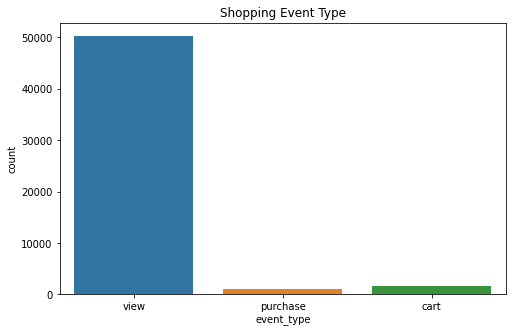

In [37]:
# Event Type
rcParams['figure.figsize'] = 8, 5
sns.countplot(data=shopping_sample, x='event_type')
plt.title('Shopping Event Type')
# For the selected sample, approx. 95% of the shoppers were viewing products than it was put in cart or purchased

Text(0.5, 1.0, 'Shopping TIme and Event Type')

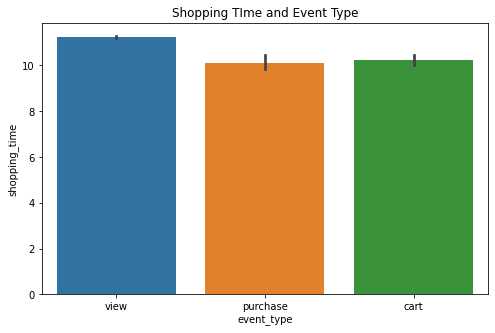

In [38]:
# Shopping Time and Event Type
rcParams['figure.figsize'] = 8, 5
ax = sns.barplot(data=shopping_sample, x='event_type', y='shopping_time')
plt.title('Shopping TIme and Event Type')

Text(0.5, 1.0, 'Shopping Category with Price and Event Type')

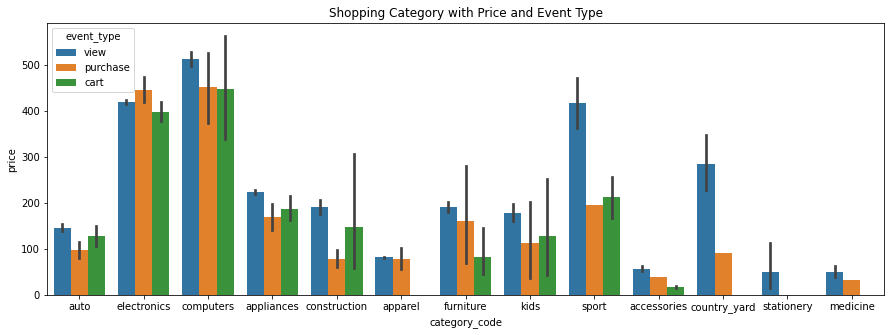

In [39]:
# Shopping Category and Price
rcParams['figure.figsize'] = 15, 5
ax = sns.barplot(data=shopping_sample, x='category_code', y='price', hue='event_type')
plt.title('Shopping Category with Price and Event Type')
# For the selected sample, 'electronics' and 'computers' are the most purchased shopping categories. They are also on the top product in the view and in-cart event_type.

In [40]:
top25_product_list = shopping_sample['product_code'].value_counts().iloc[:25].index

In [41]:
top25_product_df = shopping_sample.loc[shopping_sample['product_code'].isin(top25_product_list)]

Text(0.5, 1.0, 'Top 25 Shopping Product with Price and Event Type')

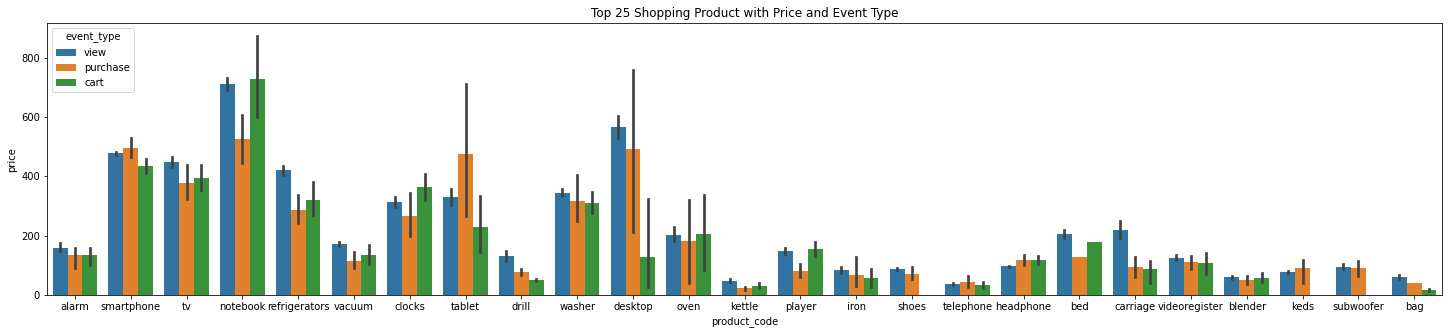

In [42]:
# Top 25 Shopping Products and Price
rcParams['figure.figsize'] = 25, 5
ax = sns.barplot(data=top25_product_df, x='product_code', y='price', hue='event_type')
plt.title('Top 25 Shopping Product with Price and Event Type')
# For the selected sample, 'notebook', 'smartphone', 'tablet' and 'desktop' are the most purchased shopping products. They are also on the top shopping products in the view and in-cart event_type.

In [43]:
top25_brand_list = shopping_sample['brand'].value_counts().iloc[:25].index

In [44]:
top25_brand_df = shopping_sample.loc[shopping_sample['brand'].isin(top25_brand_list)]

Text(0.5, 1.0, 'Top 25 Shopping Brands with Price and Event Type')

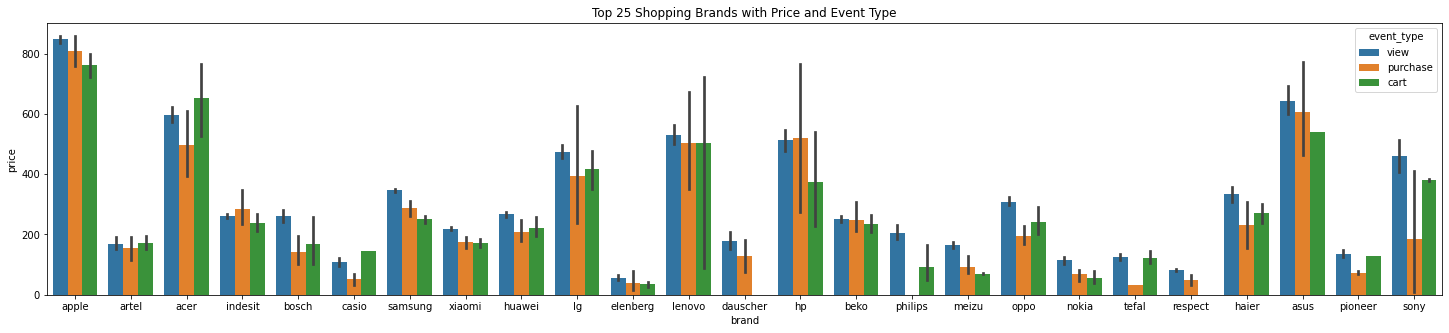

In [45]:
# Top 25 Shopping Brands and Price
rcParams['figure.figsize'] = 25, 5
ax = sns.barplot(data=top25_brand_df, x='brand', y='price', hue='event_type')
plt.title('Top 25 Shopping Brands with Price and Event Type')
# For the selected sample, 'apple', 'asus', 'lenovo' and 'hp' are the most purchased shopping brands. They are also on the top shopping brands in the view and in-cart event_type.

Text(0.5, 1.0, 'Shopping Category with Shopping Time and Event Type')

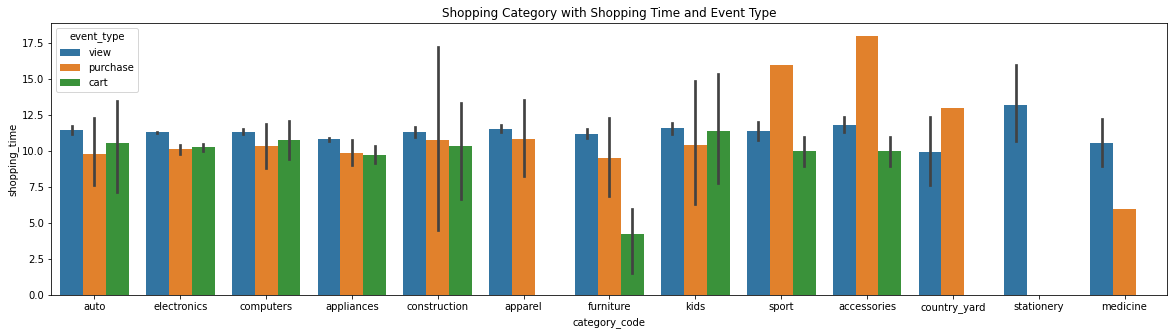

In [46]:
# Shopping Category with Shopping Time and Event Type
rcParams['figure.figsize'] = 20, 5
ax = sns.barplot(data=shopping_sample, x='category_code', y='shopping_time', hue='event_type')
plt.title('Shopping Category with Shopping Time and Event Type')
# For the selected sample, 'accessories' and 'sport' shopping categories shows the higest shopping time but both of them ended up in purchases.

Text(0.5, 1.0, 'Top 25 Shopping Product with Shopping Time and Event Type')

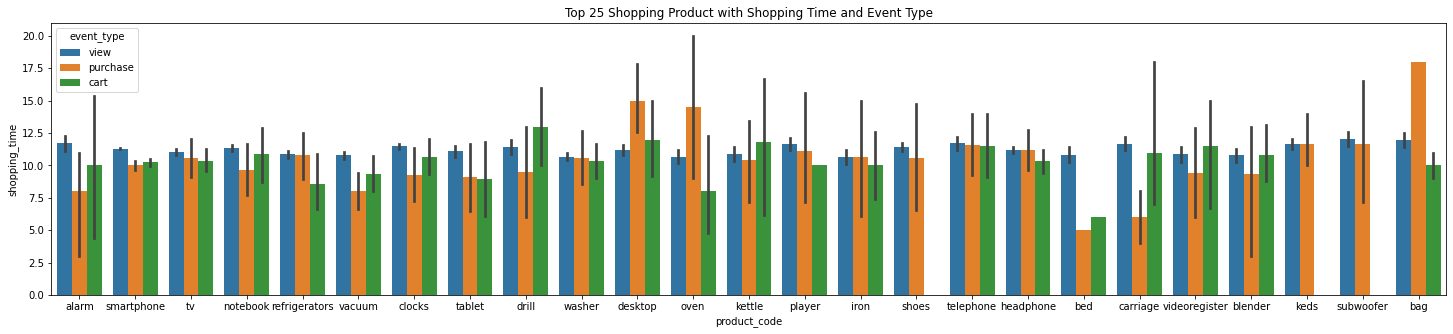

In [47]:
# Shopping Product with Shopping Time and Event Type
rcParams['figure.figsize'] = 25, 5
ax = sns.barplot(data=top25_product_df, x='product_code', y='shopping_time', hue='event_type')
plt.title('Top 25 Shopping Product with Shopping Time and Event Type')
# For the selected sample, 'bag', 'desktop', and 'oven' shopping products shows the higest shopping time but all of them ended up in purchases.

Text(0.5, 1.0, 'Top 25 Shopping Brands with Shopping Time and Event Type')

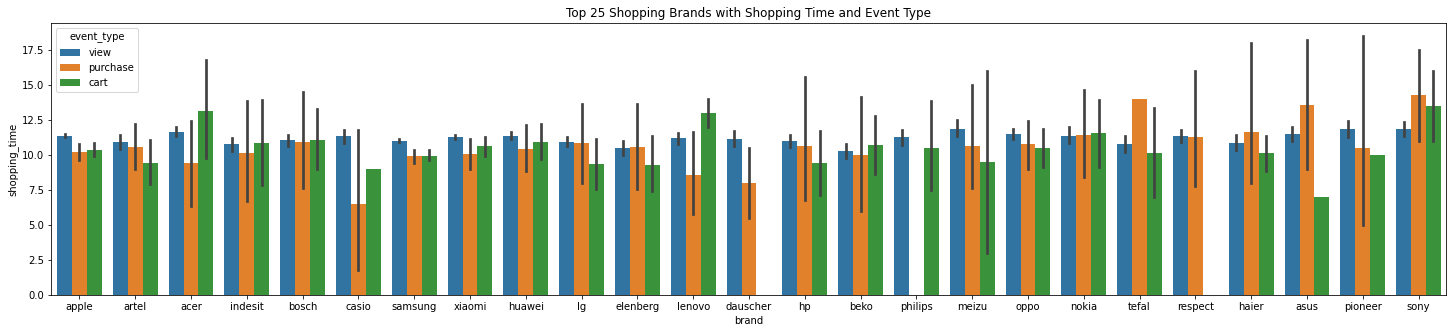

In [48]:
# Top 25 Shopping Brands with Shopping Time and Event Type
rcParams['figure.figsize'] = 25, 5
ax = sns.barplot(data=top25_brand_df, x='brand', y='shopping_time', hue='event_type')
plt.title('Top 25 Shopping Brands with Shopping Time and Event Type')
# For the selected sample, 'sony', 'asus', and 'tefal' shopping brands shows the higest shopping time but all of them ended up in purchases.